# Tratando dados ausentes

Normalmente é muito empolgante começar uma nova modelagem de machine learning \o/

Mas quando descobrimos que nosso principal dataset tem um monte de dados faltando, bate uma certa preocupação...  
São os temidos **"missing data"** ou **"missing values"**.

<img src="images/dados_ausentes_learnison.jpg" align="left" width="200">
Nosso amigo Learnison está passando exatamente por isso:<br>
─ O que farei com esses buracos nos dados?
<br><br>
Seu primeiro impulso foi de simplesmente remover todas as linhas e colunas com dados ausentes.<br>
Mas depois reconsiderou:<br>
─ Acho que estou sendo radical... Talvez a melhor solução seja preencher esses buracos com algum valor default.
<br><br>
Uma angústia, entretanto, continuou o incomodando em background:<br>
─ Isso poderá comprometer a qualidade do meu modelo?

Então ele respirou fundo, meditou um pouco e decidiu abordar o problema com a mente *zen* agitação 😜

## Será mesmo?
Sua primeira ação foi confirmar se o dataset foi baixado corretamente da origem.  
Pode parecer uma atitude ingênua, mas **uma simples verificação** pode evitar muitas horas de dor de cabeça infrutíferas.
* Conferir se o arquivo não se corrompeu durante a transferência.
* Se o arquivo não for grande, pode baixar novamente e comparar.
* Se o dataset veio de um banco de dados, consultar diretamente o banco e verificar se os dados também estão ausentes lá.

## Sim :/
Porém, existe a indesejada possibilidade de os **dados estarem realmente ausentes** (o que neste caso ocorreu).  
Learnison, então, foi em frente e colocou a mão na massa, *ops*, nos dados. <br>
Vamos acompanhá-lo!

> **OBS:** Por motivos pessoais, Learnison não permitiu usarmos o seu dataset de *poderes mágicos*. Por isso, usaremos o popular dataset do naufrágio do Titanic disponível no Kaggle.
> 
> No site do Kaggle, o dataset está dividido em arquivos separados (treino e teste), prontos para uso na machine learning. 
Mas preferimos baixar o arquivo único, que existe na seguinte URL: https://hbiostat.org/data/repo/titanic3.xls
> 
> E para as descrições dos atributos, consultamos o Kaggle mesmo: https://www.kaggle.com/c/titanic/data

<img src="images/icons8-pesquisar-96.png" width="50">

## Desvendando os dados

─ Primeiro vou carregar os dados num dataframe Pandas para conhecer a estrutura e o conteúdo deste dataset.

In [1]:
import pandas as pd

In [2]:
url = "https://hbiostat.org/data/repo/titanic3.xls"
df = pd.read_excel(url)

### Prazer em conhecê-los!
─ Novo dataset, novas surpresas! Agradáveis ou desagradáveis...
Não tenho a mínima ideia de sua estrutura e conteúdo.  
Podem haver 100 linhas ou 100 milhões. Podem ter 10 atributos ou 500. Tudo é possível.  
No máximo, posso imaginar o volume dos dados pelo tempo que demoram para carregar no dataframe.

─ Ainda bem que o Pandas facilita bastante nossa vida.  
Para saber o volume, uso o **shape**.

In [3]:
df.shape

(1309, 14)

─ Blz, um dataset tranquilo: 1309 linhas e 14 colunas.  
Para conhecer os atributos e seus data types, uso o método **info()**.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pclass     1309 non-null   int64  
 1   survived   1309 non-null   int64  
 2   name       1309 non-null   object 
 3   sex        1309 non-null   object 
 4   age        1046 non-null   float64
 5   sibsp      1309 non-null   int64  
 6   parch      1309 non-null   int64  
 7   ticket     1309 non-null   object 
 8   fare       1308 non-null   float64
 9   cabin      295 non-null    object 
 10  embarked   1307 non-null   object 
 11  boat       486 non-null    object 
 12  body       121 non-null    float64
 13  home.dest  745 non-null    object 
dtypes: float64(3), int64(4), object(7)
memory usage: 143.3+ KB


─ Uau, muito útil este info!

Além dos nomes e dtypes dos atributos, também já diz quantos valores não-nulos existem em cada coluna.  
E no final também informa o uso de memória do dataframe.

**Obs 1:** Para saber o uso completo de memória, usar **df.info(memory_usage="deep")**.

**Obs 2:** Não é nosso objetivo agora, mas é possível usar **df.describe()** para ter uma visão geral estatística dos valores **numéricos**.

### Ausentes, quem são vocês?
─ Ok, pelo info() já sei que existem 7 atributos com buracos nos dados.  
Como confio parcialmente no *olhômetro*, é bom confirmar isso pelo Pandas:

In [5]:
print("Quantos:", df.isnull().any().sum())
print("Quais:", df.columns[df.isnull().any()])

Quantos: 7
Quais: Index(['age', 'fare', 'cabin', 'embarked', 'boat', 'body', 'home.dest'], dtype='object')


─ É importante entender exatamente a que se refere cada atributo.  
Só pelo nome, não dá para ter certeza sobre seu conteúdo. Por isso, consulto o dicionário de dados do dataset:
* age - idade do passageiro em anos
* fare - preço da passagem
* cabin - número da cabine do passageiro
* embarked - porto onde embarcou (C = Cherbourg, Q = Queenstown, S = Southampton)
* boat - número do bote salva-vidas (caso tenha sobrevivido)
* body - número de identificação do corpo (caso tenha morrido e recuperado)
* home.dest - cidades origem/destino

<img src="images/icons8-pyramid-toy-96.png" width="60">

## Tratando os dados

─ Agora sim, conhecendo melhor os atributos que faltam dados, posso limar aqueles que não serão úteis para minha predição no modelo de machine learning. Os que me chamam a atenção inicialmente são o "boat" e "body".


Eles são chamados de **leaky features** (atributos com vazamento de informação). Ou seja, o número do bote ou o número do corpo predizem, indiretamente, que o passageiro sobreviveu ou morreu. Logo, não devem ser usados no modelo. Já existe a feature com esta informação determinada, o atributo "survived".

### dropna()
─ Sei que o Pandas tem o método dropna() que é muito poderoso para remover linhas ou colunas que possuem dados ausentes.  
Mas antes quero recordar os seus principais parâmetros para utilizá-lo.
* df.dropna() - remove todas as linhas que possuem, ao menos, um dado ausente (NaN).
* df.dropna(how='all') - remove todas as linhas em que **todos** conteúdos das colunas forem NaN.

Na remoção de linhas, para considerar somente um subconjunto de colunas, usar **subset**:
* df.dropna(subset=['col1', 'col2'...])

Para remover colunas, especificar o axis (eixo) 1 (columns):
* df.dropna(axis=1) - remove todas as colunas que possuem, ao menos, um dado ausente (NaN).
* df.dropna(axis=1, how='all') - remove todas as colunas em que **todos** conteúdos das linhas forem NaN.

**OBS:** O Pandas usa o termo "**NaN**" para indicar um dado ausente.  
Significa "not a number", um legado da biblioteca NumPy. Mas vale para quaisquer atributos, não só os numéricos. Exemplo:

In [6]:
df[df['boat'].isnull()].head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
2,1,0,"Allison, Miss. Helen Loraine",female,2.0,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
7,1,0,"Andrews, Mr. Thomas Jr",male,39.0,0,0,112050,0.0000,A36,S,NaN,NaN,"Belfast, NI"
9,1,0,"Artagaveytia, Mr. Ramon",male,71.0,0,0,PC 17609,49.5042,NaN,C,NaN,22.0,"Montevideo, Uruguay"


<img src="images/icons8-recortar-96.png" width="50">

─ Existem duas maneiras de remover as colunas 'boat' e 'body'. Ambas funcionam:

In [7]:
df.drop(['boat', 'body'], axis=1)    # Ou: df.drop(columns=['boat', 'body'])

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,"Montreal, PQ / Chesterville, ON"
...,...,...,...,...,...,...,...,...,...,...,...,...
1304,3,0,"Zabour, Miss. Hileni",female,14.5000,1,0,2665,14.4542,NaN,C,NaN
1305,3,0,"Zabour, Miss. Thamine",female,NaN,1,0,2665,14.4542,NaN,C,NaN
1306,3,0,"Zakarian, Mr. Mapriededer",male,26.5000,0,0,2656,7.2250,NaN,C,NaN
1307,3,0,"Zakarian, Mr. Ortin",male,27.0000,0,0,2670,7.2250,NaN,C,NaN


─ O Pandas foi legal e até exibiu uma amostra do dataset sem as colunas removidas.  
Vejo que, das 14 iniciais, sobraram 12 colunas. Vou confirmar com o "shape".

In [8]:
df.shape

(1309, 14)

<img src="images/icons8-grito-96.png" width="70">

─ Eita, mas o que é isso!  
Continuam 14 colunas! Será que as duas colunas não foram removidas?  
Pois é verdade. Alguns métodos do Pandas retornam uma cópia do dataframe, isto é, não modificam o dataframe original.  
Mas existem duas maneiras simples de contornar isso:

In [9]:
df = df.drop(['boat', 'body'], axis=1)    # Ou: df.drop(['boat', 'body'], axis=1, inplace=True)
df.shape

(1309, 12)

─ Pronto, removidas!<br>
Mas restam ainda 5 atributos com dados ausentes.
* age - idade do passageiro em anos
* fare - preço da passagem
* cabin - número da cabine do passageiro
* embarked - porto onde embarcou (C = Cherbourg, Q = Queenstown, S = Southampton)
* home.dest - cidades origem/destino

<img src="images/icons8-chá-96.png" width="60">

─ Blz, vamos com calma... Pra começar, quero saber:

* Qual a quantidade de dados ausentes de cada um?  
* E quantos são em valor absoluto e em percentual?

In [10]:
df[['age', 'fare', 'cabin', 'embarked', 'home.dest']].isnull().agg(['sum', 'mean']).T

,sum,mean
age,263.0,0.200917
fare,1.0,0.000764
cabin,1014.0,0.774637
embarked,2.0,0.001528
home.dest,564.0,0.430863


─ Humm, alguns são mais preocupantes...  
"cabin" tem 77% de dados não informados e "home.dest" 43%.

─ O percentual de "age" não é tão alto, mas são 20% dos passageiros sem a informação de idade.  
E é uma variável (*feature*) importante para o modelo, porque um jovem teria mais chance de sobreviver do que um idoso ou uma criança.  
Vou começar por ele.

### Age
─ Pra começar, quero ver como está a distribuição das idades em relação ao conjunto de dados completo.  
Isso é fácil usando o gráfico histograma do Pandas:

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

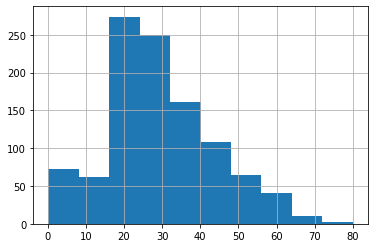

In [12]:
df['age'].hist(bins=10)
plt.show()

─ Para visualizar o quanto as idades ausentes afetam o conjunto completo, substituo os valores nulos por outro bem distante, por exemplo, -100. 

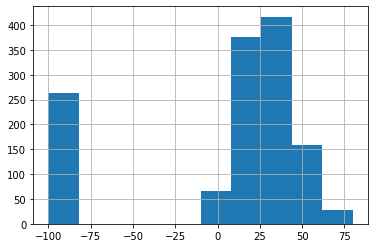

In [13]:
import numpy as np    # NumPy importado para referenciar a constante "NaN" como "np.nan".
df['age'].replace(np.nan, -100).hist(bins=10)
plt.show()

─ Mas será que essas idades não informadas referem-se a um determinado padrão de passageiros?  
Ou a um determinado padrão no dataset? Por exemplo, somente os últimos registros?  
Ou estão ausentes de forma aleatória?  
Será que houve displicência quando cadastraram as datas de nascimento dos passageiros?

─ Lembrei que existe um gráfico que ilustra bem a distribuição dos dados ausentes. Fica na bilioteca "missingno".

In [14]:
import missingno as msno
import warnings
warnings.filterwarnings('ignore')

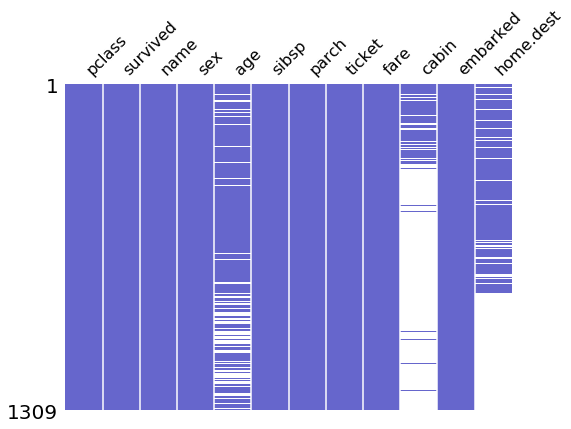

In [15]:
fig, ax = plt.subplots(figsize=(8, 6))
msno.matrix(df, color=(0.4, 0.4, 0.8), ax=ax)
plt.show()

<img src="images/icons8-sherlock-holmes-96.png" width="60">

─ Ora, ora, os buracos nas idades estão bem aleatórios.  
Logo, vale a pena preenchê-los com algum valor que colabore com o machine learning.  
Qual poderia ser?  
* Colocar 0 iria distorcer a realidade... 20% de bebês a bordo?
* Uma opção razoável é preencher com a média das idades dos passageiros.

─ Preencho os valores nulos usando o método **fillna()** do Pandas.  
O valor preenchido pode ser fixo ou algo calculado. Neste caso, será a média da coluna "age".

In [16]:
print("Média inicial:", df['age'].mean())

df['age'].fillna((df['age'].mean()), inplace=True)

print("Média após o fillna:", df['age'].mean())

Média inicial: 29.8811345124283
Média após o fillna: 29.881134512428297


─ Admito que esta solução parece simplista. Mas vale a pena para não perder 20% dos dados.

### Fare
─ Oba, o atributo "fare" (preço da passagem) só tem 1 ausente.  
Provavelmente algum carona :D

─ Acho que tanto faz preencher com o valor médio ou simplesmente remover a linha.  
Não deve impactar o modelo.  
Só que, desta vez, ao invés do Pandas, usarei a classe **SimpleImputer** da biblioteca scikit-learn.

In [17]:
from sklearn.impute import SimpleImputer

In [18]:
imp = SimpleImputer()
df[['fare']] = imp.fit_transform(df[['fare']])    # usar dataframe e não series como parâmetro
df['fare'].isnull().sum()

0

**Obs:** Por default, os valores nulos (np.nan) serão preenchidos com a média (strategy='mean'). Outras opções são:
* SimpleImputer(strategy='most_frequent')
* SimpleImputer(strategy='median')
* SimpleImputer(strategy='constant', fill_value=99)

### Cabin

<img src="images/titanic_design.jpg" width="500">

─ Encontrei na internet essa imagem que mostra a localização das instalações no Titanic.  
Não imagino porque a informação do número da cabine está ausente para vários passageiros, conforme mostrou o gráfico "matrix" do **missingno**.

─ A princípio, a localização da cabine poderá influenciar se o passageiro sobreviveu ou não. Ou seja, é um atributo útil para o modelo.  
Vou criar uma nova coluna no dataframe do tipo booleana, retornando true ou false dependendo se o passageiro tem ou não cabine.

In [19]:
df['with_cabin'] = df['cabin'].notnull()
df['with_cabin'].value_counts()

False    1014
True      295
Name: with_cabin, dtype: int64

─ Mas será que quem não tinha cabine teve menor chance de sobreviver?  
Vou **agrupar** o dataframe pelos 2 atributos ("with_cabin" e "survived") para ver os quantitativos.

In [20]:
# Retorna uma series multiindex com os totais agrupados pelas 2 colunas
group = df.groupby(['with_cabin', 'survived'])['with_cabin'].count()
group

with_cabin  survived
False       0           707
            1           307
True        0           102
            1           193
Name: with_cabin, dtype: int64

─ Descubro que, dos que tinham cabine (295), os sobreviventes (193) não foram tão superiores (193/295 = 65%).

─ E dos passageiros que não tinham cabine não posso afirmar nada.   
Não sei se não tinham mesmo ou se simplesmente os dados não foram preenchidos.   
Ou se afundaram junto com o Titanic 😆

<img src="images/icons8-gráfico-de-barras-96.png" width="60">

─ Mas quero observar isso visualmente. Num gráfico.    
A vantagem do gráfico é que a gente bate o olho e já tem o ***insight***, enquanto que nos resultados numéricos demoramos um pouco para interpretar.

─ Para colocar esses dados num gráfico de barras, precisarei primeiro transformar o resultado da variável "group".  
Como é uma series multindex, uma maneira é pivotear o segundo index (survived) para coluna.  
Isso pode ser feito com o método **unstack()** do Pandas. Por default ele pivoteia o último level do index (-1):

In [21]:
# Pivoteia o último index (survived) para coluna
survived_pivoted = group.unstack()
survived_pivoted

survived,0,1
with_cabin,,
False,707,307
True,102,193


In [22]:
survived_pivoted.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2 entries, False to True
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   0       2 non-null      int64
 1   1       2 non-null      int64
dtypes: int64(2)
memory usage: 48.0+ bytes


─ Pronto, agora este dataframe pode ser usado no gráfico de barras:

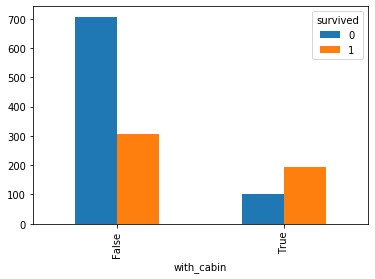

In [23]:
survived_pivoted.plot.bar()
plt.show()

─ Pesquisando na web, encontro outra forma mais simples de gerar este dataframe agrupado e pivoteado.  
Usando o "**crosstab**" do Pandas:

In [24]:
crosstab = pd.crosstab(df['with_cabin'], df['survived'])
crosstab

survived,0,1
with_cabin,,
False,707,307
True,102,193


─ O gráfico fica igual.

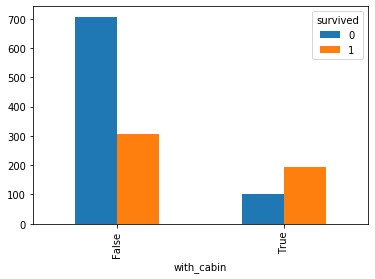

In [25]:
crosstab.plot.bar()
plt.show()

─ Acho mais interessante visualizar com as barras empilhadas (**stacked**):

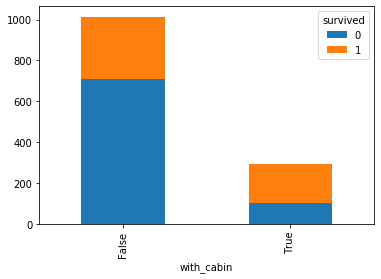

In [26]:
crosstab.plot.bar(stacked=True)
plt.show()

─ E depois de mais uma vasculhada na web encontro uma forma ainda mais simples de mostrar este gráfico...  
Usando o "**countplot**" da bibioteca **seaborn**.

In [27]:
import seaborn as sns

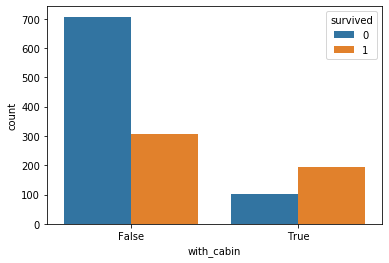

In [28]:
sns.countplot(x='with_cabin', hue='survived', data=df)
plt.show()

─ Porém, como preencher os dados que faltam?